In [18]:
import os

import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
import xrspatial
from shapely import Point, LineString, Polygon
import matplotlib.pyplot as plt
from scipy import signal

from valleys.utils import setup_wbt
from valleys.cross_section import rezero_alphas, preprocess_channel, vectorize_stream_from_hillslope_raster, rioxarray_sample_points, get_cross_section_points

In [5]:
%load_ext autoreload
%autoreload 2

In [418]:
wbt = setup_wbt(whitebox_dir=os.path.expanduser("~/opt/WBT/"), working_dir=os.path.abspath("../data/wb_outputs/"))

# 1801 12
# 1807 4
# 1804 22

dem_file = os.path.abspath("../data/huc12s/180400060403///subbasins/22.0_dem.tif")
hillslopes_file = os.path.abspath("../data/huc12s/180400060403////subbasins/22.0_hillslopes.tif")

hs = rioxarray.open_rasterio(hillslopes_file).squeeze()
dem = rioxarray.open_rasterio(dem_file).squeeze()

In [420]:
# get slope and curvature of soothed dem
wbt.gaussian_filter(dem_file, "smoothed.tif", 1.5)
wbt.slope("smoothed.tif", "slope.tif")
wbt.profile_curvature("smoothed.tif", "profile_curvature.tif", log=False)

slope_file = os.path.join(wbt.work_dir, "slope.tif")
curvature_file = os.path.join(wbt.work_dir, "profile_curvature.tif")

slope = rioxarray.open_rasterio(slope_file).squeeze()
slope = slope.where(slope != -32768)
curvature = rioxarray.open_rasterio(curvature_file).squeeze()
curvature = curvature.where(curvature != -32768)

In [421]:
stream = vectorize_stream_from_hillslope_raster(wbt, hs)
centerline = preprocess_channel(stream, method='simplify', threshold=50)

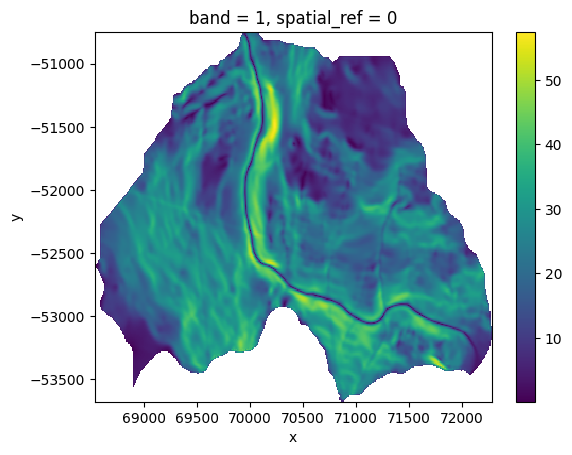

In [424]:
df = gpd.GeoDataFrame(geometry=[stream], crs=3310)
df.to_file(os.path.join(wbt.work_dir, 'streams.shp'))
wbt.rasterize_streams('streams.shp', dem_file, 'streams.tif')
wbt.fill_depressions(dem_file, 'filled.tif')
wbt.elevation_above_stream('filled.tif', 'streams.tif', 'hand.tif')
hand = rioxarray.open_rasterio(os.path.join(wbt.work_dir, "hand.tif")).squeeze()
hand = hand.where( hand != -32768)
slope.plot()

In [425]:
points = get_cross_section_points(centerline, xs_spacing=10, xs_width=200, xs_point_spacing=10)
points.head()

,alpha,point,cross_section_id
0,-200,POINT (69762.005 -50824.218),0
1,-190,POINT (69771.544 -50821.215),0
2,-180,POINT (69781.082 -50818.212),0
3,-170,POINT (69790.621 -50815.209),0
4,-160,POINT (69800.159 -50812.206),0


In [426]:
points['elevation'] = rioxarray_sample_points(hand, points)
points['slope'] = rioxarray_sample_points(slope, points)
points['curvature'] = rioxarray_sample_points(curvature, points)
points['hillslope_id'] = rioxarray_sample_points(hs, points)
points['point_id'] = range(len(points))

In [427]:
points2 = rezero_alphas(points)

In [428]:
def get_break_point(half_profile_df):
    df = half_profile_df.copy()
    df['alpha'] = df['alpha'].apply(abs)
    df = df.sort_values(by='alpha', ascending=True)
    
    peak_inds = list(signal.find_peaks(-df['curvature'], height=0.005))[0]

    # THIS IS WRONG!
    for i,ind in enumerate(peak_inds):
        if (i+1) < len(peak_inds):
            slope = (df['elevation'].iloc[(peak_inds[i+1])] - df['elevation'].iloc[ind]) / ( df['alpha'].iloc[(peak_inds[i+1])] - df['alpha'].iloc[ind])
        else:
            slope = (df['elevation'].iloc[-1] - df['elevation'].iloc[ind]) / (df['alpha'].iloc[-1] - df['alpha'].iloc[ind])
        if slope > .25:
            return df['point_id'].iloc[ind]
    return np.nan
        

In [429]:
bps = []
for id in points2['cross_section_id'].unique():
    bp_1 = get_break_point(points2.loc[(points2['cross_section_id'] == id) & (points2['alpha'] >= 0)])
    bp_2 = get_break_point(points2.loc[(points2['cross_section_id'] == id) & (points2['alpha'] <= 0)])
    if not np.isnan(bp_1):
        bps.append(bp_1)
    if not np.isnan(bp_2):
        bps.append(bp_2)



In [430]:
bp_df = points2.iloc[bps]
bp_df

,alpha,point,cross_section_id,elevation,slope,curvature,hillslope_id,point_id
21,20,POINT (70010.359 -50913.774),16,3.957886,17.496813,-0.014429,177.0,677
21,20,POINT (70013.362 -50923.312),17,3.500488,15.124899,-0.014317,177.0,718
21,20,POINT (70016.365 -50932.851),18,3.090332,12.456573,-0.014046,177.0,759
20,10,POINT (70009.829 -50945.392),19,2.675781,9.299605,-0.013759,177.0,799
18,-10,POINT (69990.753 -50951.398),19,1.458862,18.454987,-0.015773,178.0,797
...,...,...,...,...,...,...,...,...
31,130,POINT (71993.202 -53378.937),433,22.416748,19.782009,-0.005201,178.0,17784
31,130,POINT (71990.526 -53388.573),434,20.738647,17.780678,-0.005531,178.0,17825
31,120,POINT (71987.850 -53398.208),435,22.500366,18.410717,-0.005302,178.0,17866
31,120,POINT (71982.497 -53417.478),437,20.899170,17.464352,-0.005170,178.0,17948


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

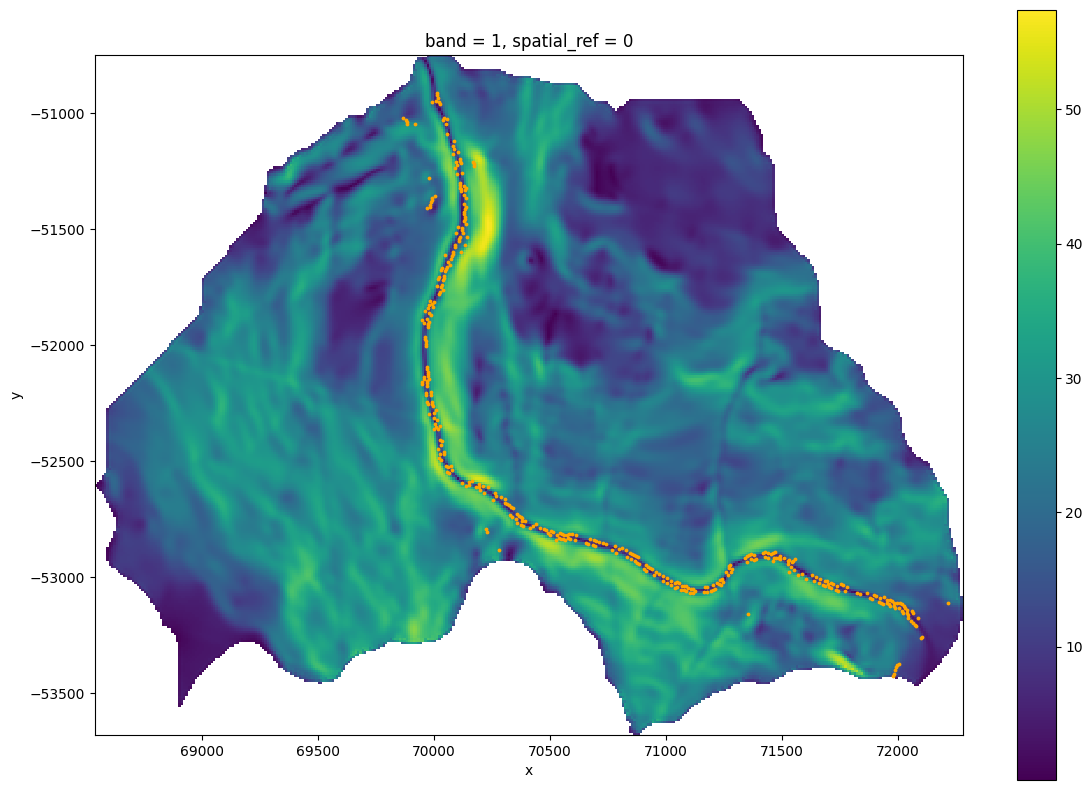

In [431]:
fig, ax = plt.subplots(figsize=(14,10))
slope.plot(ax=ax)
bp_df.plot(ax=ax, color='orange', markersize=3)

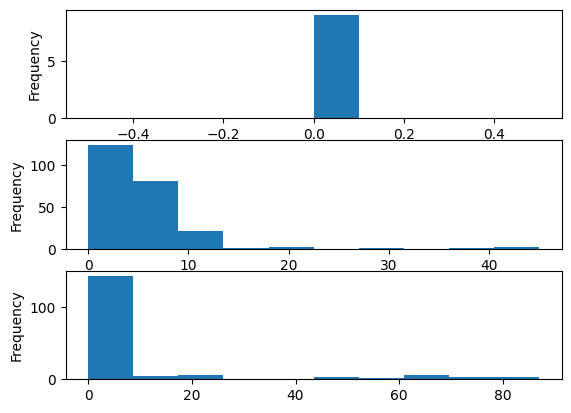

In [432]:
# group by hillslope and plot hist of elevations after binning
hgroups = bp_df.groupby('hillslope_id')

fig, axes=  plt.subplots(len(hgroups), 1)

count = 0
for g,data in hgroups:
    elev = (data['elevation']/3).round().astype(int) * 3
    elev.plot.hist(ax=axes[count])
    count +=1

<Axes: ylabel='Frequency'>

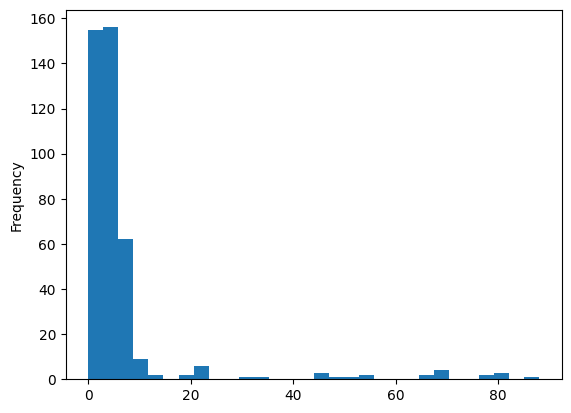

In [437]:
elev = bp_df['elevation']
elev.plot.hist(bins=30)

In [416]:
((bp_df['elevation']/ 3).round().astype(int) * 3).describe()

count    396.000000
mean       4.886364
std        3.515566
min        0.000000
25%        3.000000
50%        6.000000
75%        6.000000
max       21.000000
Name: elevation, dtype: float64

In [417]:
((bp_df['elevation']/ 3).round().astype(int) * 3).value_counts()

elevation
6     170
0      87
3      70
9      50
12     13
15      4
18      1
21      1
Name: count, dtype: int64

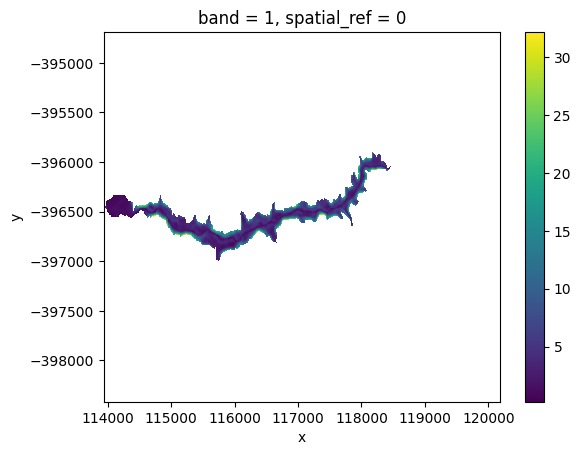

In [390]:
slope.where(hand < 12).plot()

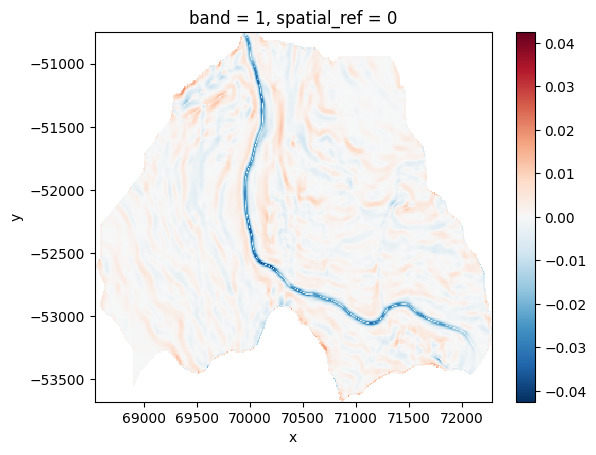

In [433]:
curvature.plot()